# Multi-City Green Space Detection
## Training SVM with WorldCover 2021 as Ground Truth

Training cities: 11 cities for robust model generalisation

- Uses WorldCover 2021 as ground truth (green classes: tree cover, shrubland, grassland, mangroves)
- Multi-temporal Sentinel-2 data (April, August, November)
- 21 bands: 4 spectral + 3 vegetation indices per month
- SGDClassifier with hinge loss (linear SVM) for scalability
- Optional RBF kernel SVM with subsampling

## 1. Import Libraries

In [1]:
import json
import os
import glob
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from pathlib import Path
import geopandas as gpd
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully")

Libraries imported successfully


## 2. Configuration

In [2]:
# Base paths - using relative paths from project root
# Run notebooks from the project root directory: python -m jupyter notebook
import os

# Find project root (go up from notebooks/training/)
if os.path.exists("data") and os.path.exists("models"):
    PROJECT_ROOT = os.getcwd()
elif os.path.exists("../../data") and os.path.exists("../../models"):
    PROJECT_ROOT = os.path.abspath("../..")
else:
    PROJECT_ROOT = os.getcwd()
    print(f"Warning: Could not detect project root. Using: {PROJECT_ROOT}")

# Derived paths
DATA_PATH = os.path.join(PROJECT_ROOT, "data")
MODELS_PATH = os.path.join(PROJECT_ROOT, "models")
GEOJSON_FOLDER = os.path.join(DATA_PATH, "aois")

# Output folder
OUTPUT_FOLDER = os.path.join(PROJECT_ROOT, "outputs", "svm_training")
os.makedirs(OUTPUT_FOLDER, exist_ok=True)
os.makedirs(MODELS_PATH, exist_ok=True)

# Create timestamped run folder
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
RUN_FOLDER = os.path.join(OUTPUT_FOLDER, f"run_{timestamp}")
os.makedirs(RUN_FOLDER, exist_ok=True)

# WorldCover green classes
GREEN_CLASSES = [10, 20, 30, 95]  # Tree, Shrub, Grass, Mangroves

# SVM Configuration
USE_RBF_KERNEL = False  # Set to True for RBF kernel (slower but potentially better)
MAX_SAMPLES_FOR_RBF = 50000  # RBF SVM is slow, limit samples

# Define cities with their specific file locations
CITY_FILES = {
    "Amsterdam": {
        "stack": os.path.join(DATA_PATH, "sentinel_stacks", "Amsterdam_MultiMonth_stack.tif"),
        "worldcover": os.path.join(DATA_PATH, "worldcover", "Amsterdam_WorldCover_2021.tif"),
        "geojson": os.path.join(GEOJSON_FOLDER, "Amsterdam.geojson"),
    },
    "Auckland": {
        "stack": os.path.join(DATA_PATH, "sentinel_stacks", "Auckland_MultiMonth_stack.tif"),
        "worldcover": os.path.join(DATA_PATH, "worldcover", "Auckland_WorldCover_2021.tif"),
        "geojson": os.path.join(GEOJSON_FOLDER, "Auckland.geojson"),
    },
    "Barcelona": {
        "stack": os.path.join(DATA_PATH, "sentinel_stacks", "Barcelona_MultiMonth_stack.tif"),
        "worldcover": os.path.join(DATA_PATH, "worldcover", "Barcelona_WorldCover_2021.tif"),
        "geojson": os.path.join(GEOJSON_FOLDER, "Barcelona.geojson"),
    },
    "Sydney": {
        "stack": os.path.join(DATA_PATH, "sentinel_stacks", "Sydney_MultiMonth_stack.tif"),
        "worldcover": os.path.join(DATA_PATH, "worldcover", "Sydney_WorldCover_2021.tif"),
        "geojson": os.path.join(GEOJSON_FOLDER, "Sydney.geojson"),
    },
    "Toronto": {
        "stack": os.path.join(DATA_PATH, "sentinel_stacks", "Toronto_MultiMonth_stack.tif"),
        "worldcover": os.path.join(DATA_PATH, "worldcover", "Toronto_WorldCover_2021.tif"),
        "geojson": os.path.join(GEOJSON_FOLDER, "Toronto.geojson"),
    },
    "Vienna": {
        "stack": os.path.join(DATA_PATH, "sentinel_stacks", "Wien_MultiMonth_stack.tif"),
        "worldcover": os.path.join(DATA_PATH, "worldcover", "Vienna_WorldCover_2021.tif"),
        "geojson": os.path.join(GEOJSON_FOLDER, "Vienna.geojson"),
    },
    "London": {
        "stack": os.path.join(DATA_PATH, "sentinel_stacks", "London_MultiMonth_stack.tif"),
        "worldcover": os.path.join(DATA_PATH, "worldcover", "London_WorldCover_2021.tif"),
        "geojson": os.path.join(GEOJSON_FOLDER, "London.geojson"),
    },
    "Melbourne": {
        "stack": os.path.join(DATA_PATH, "sentinel_stacks", "Melbourne_MultiMonth_stack.tif"),
        "worldcover": os.path.join(DATA_PATH, "worldcover", "Melbourne_WorldCover_2021.tif"),
        "geojson": os.path.join(GEOJSON_FOLDER, "Melbourne.geojson"),
    },
    "Paris": {
        "stack": os.path.join(DATA_PATH, "sentinel_stacks", "Paris_MultiMonth_stack.tif"),
        "worldcover": os.path.join(DATA_PATH, "worldcover", "Paris_WorldCover_2021.tif"),
        "geojson": os.path.join(GEOJSON_FOLDER, "Paris.geojson"),
    },
    "San_Francisco": {
        "stack": os.path.join(DATA_PATH, "sentinel_stacks", "San_Francisco_MultiMonth_stack.tif"),
        "worldcover": os.path.join(DATA_PATH, "worldcover", "San_Francisco_WorldCover_2021.tif"),
        "geojson": os.path.join(GEOJSON_FOLDER, "San_Francisco.geojson"),
    },
    "Seattle": {
        "stack": os.path.join(DATA_PATH, "sentinel_stacks", "Seattle_MultiMonth_stack.tif"),
        "worldcover": os.path.join(DATA_PATH, "worldcover", "Seattle_WorldCover_2021.tif"),
        "geojson": os.path.join(GEOJSON_FOLDER, "Seattle.geojson"),
    },
}

print("Configuration loaded")
print(f"  Project root: {PROJECT_ROOT}")
print(f"  Data path: {DATA_PATH}")
print(f"  Models path: {MODELS_PATH}")
print(f"  Output folder: {RUN_FOLDER}")
print(f"  SVM Type: {'RBF Kernel' if USE_RBF_KERNEL else 'Linear (SGD)'}")
print(f"  Target cities: {len(CITY_FILES)}")
for city in CITY_FILES:
    print(f"    - {city}")

Configuration loaded
  Project root: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city
  Data path: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/data
  Models path: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/models
  Output folder: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/outputs/svm_training/run_20260127_235115
  SVM Type: Linear (SGD)
  Target cities: 11
    - Amsterdam
    - Auckland
    - Barcelona
    - Sydney
    - Toronto
    - Vienna
    - London
    - Melbourne
    - Paris
    - San_Francisco
    - Seattle


## 3. Discover Available Cities

In [3]:
print("="*70)
print("DISCOVERING AVAILABLE CITIES")
print("="*70)

print(f"\nChecking {len(CITY_FILES)} configured cities...")

cities_data = []
missing_cities = []

for city_name, paths in CITY_FILES.items():
    stack_file = paths["stack"]
    worldcover_file = paths["worldcover"]
    geojson_file = paths["geojson"]
    
    has_stack = os.path.exists(stack_file)
    has_worldcover = os.path.exists(worldcover_file)
    has_geojson = os.path.exists(geojson_file)
    
    status_stack = "Y" if has_stack else "N"
    status_geojson = "Y" if has_geojson else "N"
    status_worldcover = "Y" if has_worldcover else "N"
    
    print(f"  {city_name:15s} - Stack: {status_stack}  GeoJSON: {status_geojson}  WorldCover: {status_worldcover}")
    
    if has_stack and has_geojson and has_worldcover:
        cities_data.append({
            "name": city_name,
            "stack_file": stack_file,
            "geojson_file": geojson_file,
            "worldcover_file": worldcover_file
        })
    else:
        missing = []
        if not has_stack: missing.append("Stack")
        if not has_geojson: missing.append("GeoJSON")
        if not has_worldcover: missing.append("WorldCover")
        missing_cities.append(f"{city_name} (missing: {', '.join(missing)})")

complete_cities = cities_data

print(f"\n{'='*70}")
print(f"Cities with complete data: {len(complete_cities)}/{len(CITY_FILES)}")
print(f"{'='*70}")

if len(complete_cities) == 0:
    raise ValueError("No cities with complete data found!")

print(f"\nReady to train with {len(complete_cities)} cities")

DISCOVERING AVAILABLE CITIES

Checking 11 configured cities...
  Amsterdam       - Stack: Y  GeoJSON: Y  WorldCover: Y
  Auckland        - Stack: Y  GeoJSON: Y  WorldCover: Y
  Barcelona       - Stack: Y  GeoJSON: Y  WorldCover: Y
  Sydney          - Stack: Y  GeoJSON: Y  WorldCover: Y
  Toronto         - Stack: Y  GeoJSON: Y  WorldCover: Y
  Vienna          - Stack: Y  GeoJSON: Y  WorldCover: Y
  London          - Stack: Y  GeoJSON: Y  WorldCover: Y
  Melbourne       - Stack: Y  GeoJSON: Y  WorldCover: Y
  Paris           - Stack: Y  GeoJSON: Y  WorldCover: Y
  San_Francisco   - Stack: Y  GeoJSON: Y  WorldCover: Y
  Seattle         - Stack: Y  GeoJSON: Y  WorldCover: Y

Cities with complete data: 11/11

Ready to train with 11 cities


## 4. Load and Process All Cities

In [4]:
print("\n" + "="*70)
print("LOADING AND PROCESSING ALL CITIES")
print("="*70)

EXPECTED_BANDS = None
MAX_SAMPLES_PER_CLASS_PER_CITY = 50000  # Reduced for SVM (memory constraints)

all_X = []
all_y = []
city_info = []
skipped_cities = []

for city_data in tqdm(complete_cities, desc="Processing cities"):
    city_name = city_data["name"]
    stack_file = city_data["stack_file"]
    worldcover_file = city_data["worldcover_file"]
    
    print(f"\n{'='*70}")
    print(f"Processing: {city_name}")
    print(f"{'='*70}")
    
    try:
        # Load Sentinel-2 stack
        with rasterio.open(stack_file) as src:
            X_stack = src.read()
            stack_transform = src.transform
            stack_shape = (src.height, src.width)
            stack_crs = src.crs
        
        n_bands = X_stack.shape[0]
        print(f"  Loaded Sentinel-2 stack: {X_stack.shape} ({n_bands} bands)")
        
        if EXPECTED_BANDS is None:
            EXPECTED_BANDS = n_bands
            print(f"  Setting expected bands to {EXPECTED_BANDS}")
        elif n_bands != EXPECTED_BANDS:
            print(f"  SKIPPING: Expected {EXPECTED_BANDS} bands, but found {n_bands}")
            skipped_cities.append({"name": city_name, "reason": f"Band mismatch"})
            continue
        
        # Load and reproject WorldCover
        with rasterio.open(worldcover_file) as src:
            worldcover_data = np.empty(stack_shape, dtype=np.uint8)
            reproject(
                source=rasterio.band(src, 1),
                destination=worldcover_data,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=stack_transform,
                dst_crs=stack_crs,
                resampling=Resampling.nearest
            )
        
        labels = np.isin(worldcover_data, GREEN_CLASSES).astype(np.uint8)
        green_percentage = 100 * labels.sum() / labels.size
        print(f"  WorldCover labels: {labels.shape} ({green_percentage:.2f}% green)")
        
        # Reshape for sklearn
        n_pixels = X_stack.shape[1] * X_stack.shape[2]
        X = X_stack.reshape(n_bands, -1).T
        y = labels.flatten()
        
        # Remove NaN values
        valid_mask = ~np.isnan(X).any(axis=1)
        X_clean = X[valid_mask]
        y_clean = y[valid_mask]
        
        print(f"  Valid samples: {len(X_clean):,}")
        
        # Balanced sampling
        green_indices = np.where(y_clean == 1)[0]
        nongreen_indices = np.where(y_clean == 0)[0]
        
        n_samples_per_class = min(len(green_indices), len(nongreen_indices), MAX_SAMPLES_PER_CLASS_PER_CITY)
        
        np.random.seed(42)
        sampled_green = np.random.choice(green_indices, n_samples_per_class, replace=False)
        sampled_nongreen = np.random.choice(nongreen_indices, n_samples_per_class, replace=False)
        
        sampled_indices = np.concatenate([sampled_green, sampled_nongreen])
        np.random.shuffle(sampled_indices)
        
        X_sampled = X_clean[sampled_indices]
        y_sampled = y_clean[sampled_indices]
        
        print(f"  Balanced sampling: {len(X_sampled):,} samples ({n_samples_per_class:,} per class)")
        
        all_X.append(X_sampled)
        all_y.append(y_sampled)
        city_info.extend([city_name] * len(X_sampled))
        
    except Exception as e:
        print(f"  Error processing {city_name}: {e}")
        skipped_cities.append({"name": city_name, "reason": str(e)})
        continue

print(f"\n{'='*70}")
print("DATA AGGREGATION")
print(f"{'='*70}")

if len(all_X) == 0:
    raise ValueError("No valid city data loaded!")

X_combined = np.vstack(all_X)
y_combined = np.hstack(all_y)
city_info = np.array(city_info)

print(f"\nCombined dataset:")
print(f"  Cities included: {len(all_X)}")
print(f"  Total samples: {len(X_combined):,}")
print(f"  Features (bands): {X_combined.shape[1]}")
print(f"  Green samples: {np.sum(y_combined == 1):,} ({100*np.sum(y_combined == 1)/len(y_combined):.1f}%)")
print(f"  Non-green samples: {np.sum(y_combined == 0):,} ({100*np.sum(y_combined == 0)/len(y_combined):.1f}%)")


LOADING AND PROCESSING ALL CITIES


Processing cities:   9%|▉         | 1/11 [00:00<00:01,  8.40it/s]


Processing: Amsterdam
  Loaded Sentinel-2 stack: (21, 512, 512) (21 bands)
  Setting expected bands to 21
  WorldCover labels: (512, 512) (20.54% green)
  Valid samples: 262,000
  Balanced sampling: 100,000 samples (50,000 per class)

Processing: Auckland
  Loaded Sentinel-2 stack: (21, 512, 512) (21 bands)
  WorldCover labels: (512, 512) (19.74% green)
  Valid samples: 262,046
  Balanced sampling: 100,000 samples (50,000 per class)

Processing: Barcelona
  Loaded Sentinel-2 stack: (21, 512, 512) (21 bands)
  WorldCover labels: (512, 512) (12.72% green)
  Valid samples: 262,114
  Balanced sampling: 66,708 samples (33,354 per class)

Processing: Sydney
  Loaded Sentinel-2 stack: (21, 512, 512) (21 bands)


Processing cities:  36%|███▋      | 4/11 [00:00<00:00, 17.58it/s]

  WorldCover labels: (512, 512) (19.29% green)
  Valid samples: 262,079
  Balanced sampling: 100,000 samples (50,000 per class)

Processing: Toronto
  Loaded Sentinel-2 stack: (21, 512, 512) (21 bands)
  WorldCover labels: (512, 512) (18.82% green)
  Valid samples: 262,069
  Balanced sampling: 98,638 samples (49,319 per class)

Processing: Vienna
  Loaded Sentinel-2 stack: (21, 512, 512) (21 bands)
  WorldCover labels: (512, 512) (15.66% green)
  Valid samples: 262,034
  Balanced sampling: 82,098 samples (41,049 per class)

Processing: London
  Loaded Sentinel-2 stack: (21, 512, 512) (21 bands)
  WorldCover labels: (512, 512) (20.99% green)
  Valid samples: 261,947


Processing cities:  64%|██████▎   | 7/11 [00:00<00:00, 20.07it/s]

  Balanced sampling: 100,000 samples (50,000 per class)

Processing: Melbourne
  Loaded Sentinel-2 stack: (21, 512, 512) (21 bands)
  WorldCover labels: (512, 512) (22.04% green)
  Valid samples: 262,017
  Balanced sampling: 100,000 samples (50,000 per class)

Processing: Paris


Processing cities: 100%|██████████| 11/11 [00:00<00:00, 20.53it/s]

  Loaded Sentinel-2 stack: (21, 512, 512) (21 bands)
  WorldCover labels: (512, 512) (8.92% green)
  Valid samples: 261,961
  Balanced sampling: 46,766 samples (23,383 per class)

Processing: San_Francisco
  Loaded Sentinel-2 stack: (21, 512, 512) (21 bands)
  WorldCover labels: (512, 512) (8.94% green)
  Valid samples: 261,979
  Balanced sampling: 46,882 samples (23,441 per class)

Processing: Seattle
  Loaded Sentinel-2 stack: (21, 512, 512) (21 bands)
  WorldCover labels: (512, 512) (16.45% green)
  Valid samples: 262,045
  Balanced sampling: 86,238 samples (43,119 per class)

DATA AGGREGATION

Combined dataset:
  Cities included: 11
  Total samples: 927,330
  Features (bands): 21


  Green samples: 463,665 (50.0%)
  Non-green samples: 463,665 (50.0%)


## 5. Train-Test Split & Feature Normalization

In [5]:
print("\n" + "="*70)
print("TRAIN-TEST SPLIT & FEATURE NORMALIZATION")
print("="*70)

# Split data (80-20)
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y_combined, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_combined
)

print(f"\nDataset split:")
print(f"  Training samples: {len(X_train):,}")
print(f"  Testing samples: {len(X_test):,}")

# Feature normalization (CRITICAL for SVM!)
print(f"\nApplying feature normalization (StandardScaler)...")
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"  Features normalized")
print(f"    Mean (train): {X_train_scaled.mean():.4f}")
print(f"    Std (train): {X_train_scaled.std():.4f}")


TRAIN-TEST SPLIT & FEATURE NORMALIZATION

Dataset split:
  Training samples: 741,864
  Testing samples: 185,466

Applying feature normalization (StandardScaler)...
  Features normalized
    Mean (train): -0.0000
    Std (train): 1.0000


## 6. Train SVM Model

Two options:
1. **Linear SVM (SGDClassifier)**: Fast, scales to large datasets
2. **RBF Kernel SVM**: Better for non-linear boundaries, but slower

In [6]:
print("\n" + "="*70)
print("TRAINING SVM MODEL")
print("="*70)

if USE_RBF_KERNEL:
    # RBF Kernel SVM (slower but potentially better)
    print(f"\nUsing RBF Kernel SVM")
    
    # Subsample for RBF SVM if dataset is too large
    if len(X_train_scaled) > MAX_SAMPLES_FOR_RBF:
        print(f"  Subsampling to {MAX_SAMPLES_FOR_RBF:,} samples for RBF kernel...")
        np.random.seed(42)
        indices = np.random.choice(len(X_train_scaled), MAX_SAMPLES_FOR_RBF, replace=False)
        X_train_svm = X_train_scaled[indices]
        y_train_svm = y_train[indices]
    else:
        X_train_svm = X_train_scaled
        y_train_svm = y_train
    
    svm = SVC(
        kernel='rbf',
        C=1.0,
        gamma='scale',
        class_weight='balanced',
        random_state=42,
        verbose=True,
        probability=True  # Enable probability estimates
    )
    
    print(f"\nSVM Parameters:")
    print(f"  kernel: rbf")
    print(f"  C: 1.0")
    print(f"  gamma: scale")
    print(f"  Training samples: {len(X_train_svm):,}")
    
    print(f"\nTraining RBF SVM (this may take a while)...")
    svm.fit(X_train_svm, y_train_svm)
    
else:
    # Linear SVM using SGDClassifier (fast and scalable)
    print(f"\nUsing Linear SVM (SGDClassifier with hinge loss)")
    
    svm = SGDClassifier(
        loss='hinge',  # Hinge loss = linear SVM
        penalty='l2',
        alpha=0.0001,
        max_iter=1000,
        tol=1e-3,
        class_weight='balanced',
        random_state=42,
        n_jobs=-1,
        verbose=1
    )
    
    print(f"\nSGDClassifier Parameters:")
    print(f"  loss: hinge (linear SVM)")
    print(f"  penalty: l2")
    print(f"  alpha: 0.0001")
    print(f"  max_iter: 1000")
    print(f"  class_weight: balanced")
    print(f"  Training samples: {len(X_train_scaled):,}")
    
    print(f"\nTraining Linear SVM...")
    svm.fit(X_train_scaled, y_train)

print(f"\nModel trained successfully")


TRAINING SVM MODEL

Using Linear SVM (SGDClassifier with hinge loss)

SGDClassifier Parameters:
  loss: hinge (linear SVM)
  penalty: l2
  alpha: 0.0001
  max_iter: 1000
  class_weight: balanced
  Training samples: 741,864

Training Linear SVM...
-- Epoch 1
Norm: 1.98, NNZs: 21, Bias: 0.198554, T: 741864, Avg. loss: 0.450752, Objective: 0.456295
Total training time: 0.08 seconds.
-- Epoch 2
Norm: 2.19, NNZs: 21, Bias: 0.124841, T: 1483728, Avg. loss: 0.310110, Objective: 0.310392
Total training time: 0.16 seconds.
-- Epoch 3
Norm: 2.07, NNZs: 21, Bias: 0.144818, T: 2225592, Avg. loss: 0.301312, Objective: 0.301544
Total training time: 0.24 seconds.
-- Epoch 4
Norm: 2.09, NNZs: 21, Bias: 0.204635, T: 2967456, Avg. loss: 0.298793, Objective: 0.299013
Total training time: 0.31 seconds.
-- Epoch 5
Norm: 2.12, NNZs: 21, Bias: 0.094618, T: 3709320, Avg. loss: 0.297722, Objective: 0.297940
Total training time: 0.39 seconds.
-- Epoch 6
Norm: 2.08, NNZs: 21, Bias: 0.158244, T: 4451184, Avg. lo

## 7. Evaluate Model Performance

In [7]:
print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70)

# Make predictions
y_pred = svm.predict(X_test_scaled)

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, zero_division=0)
recall = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print(f"\nModel Performance (SVM):")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f"\nConfusion Matrix:")
print(f"                 Predicted")
print(f"               Non-Green  Green")
print(f"Actual Non-Green  {cm[0,0]:>8,}  {cm[0,1]:>8,}")
print(f"       Green      {cm[1,0]:>8,}  {cm[1,1]:>8,}")

# Green detection analysis
total_actual_green = cm[1,0] + cm[1,1]
green_detected = 100 * cm[1,1] / total_actual_green if total_actual_green > 0 else 0
green_missed = 100 * cm[1,0] / total_actual_green if total_actual_green > 0 else 0

print(f"\nGreen Detection Analysis:")
print(f"  Green correctly detected: {green_detected:.1f}%")
print(f"  Green missed: {green_missed:.1f}%")

# Save metrics
metrics = {
    "model": "SVM_RBF" if USE_RBF_KERNEL else "SVM_Linear",
    "ground_truth": "WorldCover_2021",
    "training_cities": [city['name'] for city in complete_cities],
    "n_cities": len(complete_cities),
    "total_training_samples": int(len(X_train)),
    "total_testing_samples": int(len(X_test)),
    "accuracy": float(accuracy),
    "precision": float(precision),
    "recall": float(recall),
    "f1_score": float(f1),
    "confusion_matrix": cm.tolist()
}

with open(os.path.join(RUN_FOLDER, "metrics.json"), "w") as f:
    json.dump(metrics, f, indent=2)

print(f"\nMetrics saved to: {RUN_FOLDER}/metrics.json")


MODEL EVALUATION

Model Performance (SVM):
  Accuracy:  0.8775
  Precision: 0.8815
  Recall:    0.8723
  F1-Score:  0.8769

Confusion Matrix:
                 Predicted
               Non-Green  Green
Actual Non-Green    81,860    10,873
       Green        11,843    80,890

Green Detection Analysis:
  Green correctly detected: 87.2%
  Green missed: 12.8%

Metrics saved to: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/outputs/svm_training/run_20260127_235115/metrics.json


## 8. Visualize Confusion Matrix

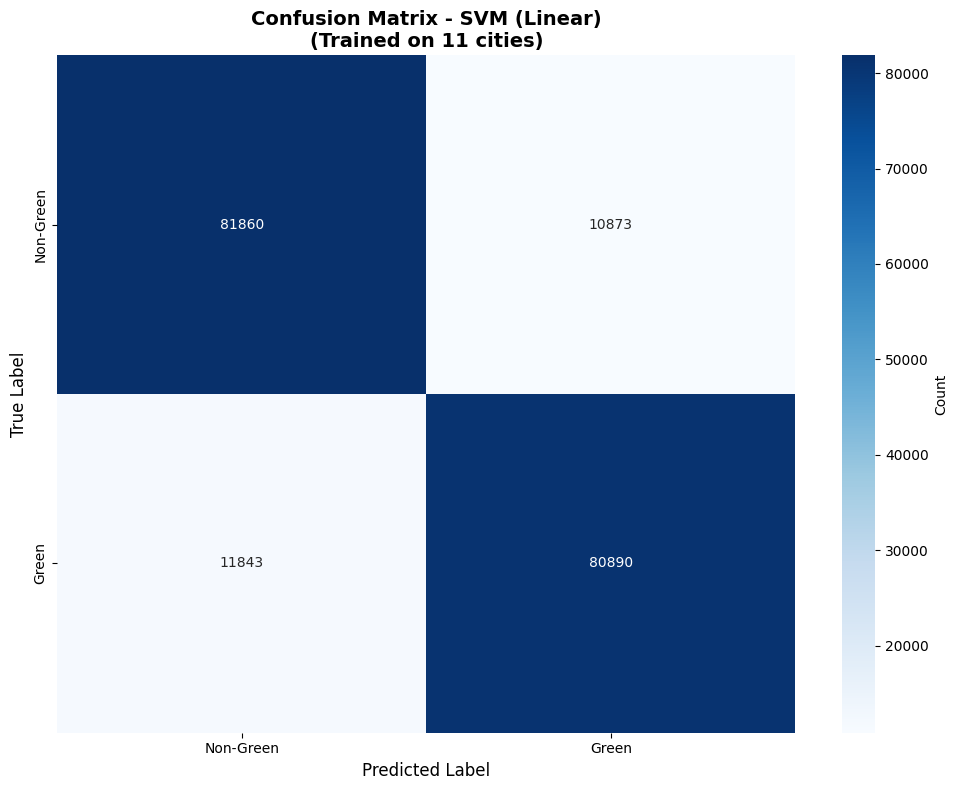

Confusion matrix saved


In [8]:
# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Non-Green', 'Green'],
            yticklabels=['Non-Green', 'Green'],
            cbar_kws={'label': 'Count'})
plt.title(f'Confusion Matrix - SVM ({"RBF" if USE_RBF_KERNEL else "Linear"})\n(Trained on {len(complete_cities)} cities)', 
          fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
plt.savefig(os.path.join(RUN_FOLDER, 'confusion_matrix.png'), dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrix saved")

## 9. Feature Importance Analysis (Linear SVM Only)

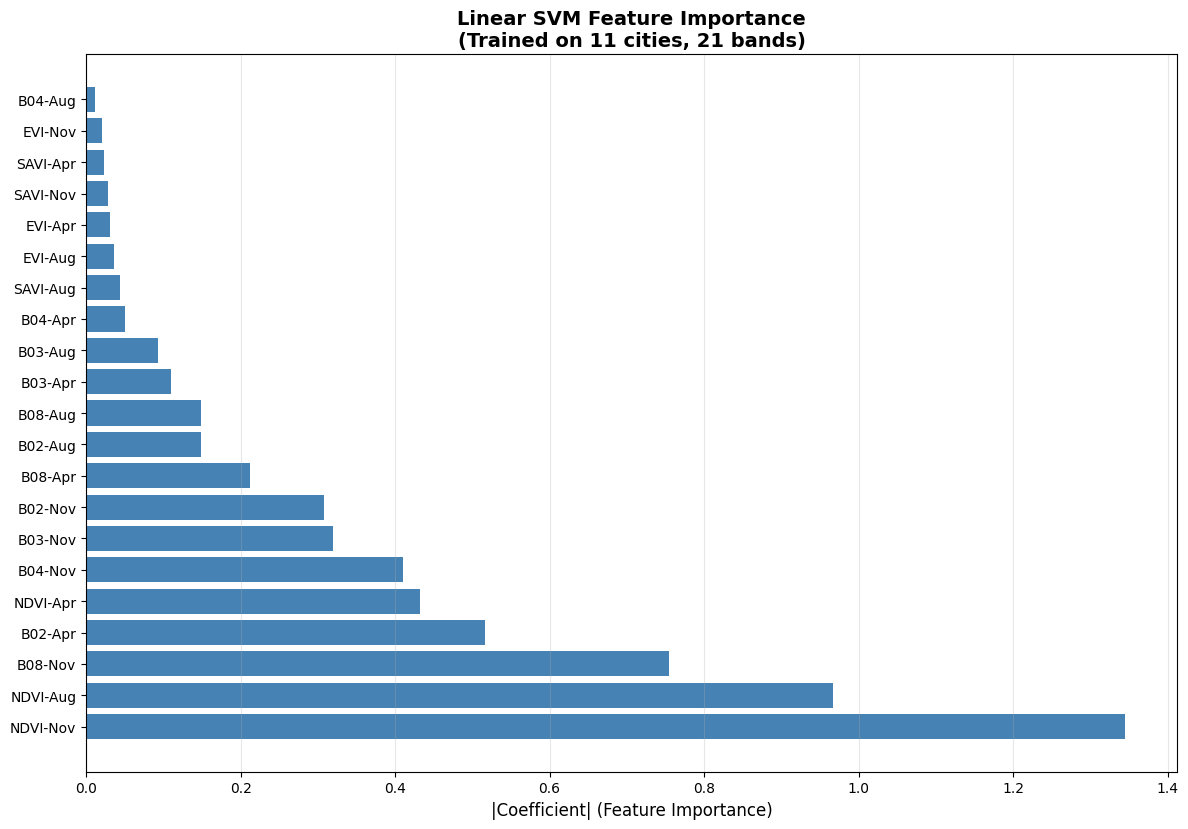

Feature importance plot saved

Top 10 most important features:
   1. NDVI-Nov    : 1.3447
   2. NDVI-Aug    : 0.9662
   3. B08-Nov     : 0.7543
   4. B02-Apr     : 0.5168
   5. NDVI-Apr    : 0.4322
   6. B04-Nov     : 0.4101
   7. B03-Nov     : 0.3190
   8. B02-Nov     : 0.3079
   9. B08-Apr     : 0.2119
  10. B02-Aug     : 0.1485


In [9]:
if not USE_RBF_KERNEL:
    # For linear SVM, we can look at coefficient magnitudes as feature importance
    importances = np.abs(svm.coef_[0])
    n_features = len(importances)
    
    # Generate band names
    if n_features == 21:
        band_names = [
            'B02-Apr', 'B03-Apr', 'B04-Apr', 'B08-Apr', 'NDVI-Apr', 'EVI-Apr', 'SAVI-Apr',
            'B02-Aug', 'B03-Aug', 'B04-Aug', 'B08-Aug', 'NDVI-Aug', 'EVI-Aug', 'SAVI-Aug',
            'B02-Nov', 'B03-Nov', 'B04-Nov', 'B08-Nov', 'NDVI-Nov', 'EVI-Nov', 'SAVI-Nov'
        ]
    else:
        band_names = [f'Band_{i+1}' for i in range(n_features)]
    
    # Sort by importance
    indices = np.argsort(importances)[::-1]
    
    # Plot
    plt.figure(figsize=(12, max(8, n_features * 0.4)))
    plt.barh(range(len(importances)), importances[indices], color='steelblue')
    plt.yticks(range(len(importances)), [band_names[i] for i in indices])
    plt.xlabel('|Coefficient| (Feature Importance)', fontsize=12)
    plt.title(f'Linear SVM Feature Importance\n(Trained on {len(all_X)} cities, {n_features} bands)', 
              fontsize=14, fontweight='bold')
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.savefig(os.path.join(RUN_FOLDER, 'feature_importance.png'), dpi=300, bbox_inches='tight')
    plt.show()
    
    print("Feature importance plot saved")
    print(f"\nTop 10 most important features:")
    for i in range(min(10, len(importances))):
        idx = indices[i]
        print(f"  {i+1:2d}. {band_names[idx]:12s}: {importances[idx]:.4f}")
else:
    print("Feature importance not available for RBF kernel SVM")

## 10. Save Trained Model

In [10]:
import joblib

# Save the trained model
model_file = os.path.join(RUN_FOLDER, 'svm_model.pkl')
joblib.dump(svm, model_file)

# Save the scaler
scaler_file = os.path.join(RUN_FOLDER, 'feature_scaler.pkl')
joblib.dump(scaler, scaler_file)

print(f"Model saved to: {model_file}")
print(f"Scaler saved to: {scaler_file}")
print(f"\nTo load the model and scaler later:")
print(f"  import joblib")
print(f"  svm = joblib.load('{model_file}')")
print(f"  scaler = joblib.load('{scaler_file}')")
print(f"\nIMPORTANT: Always apply scaler.transform(X) before prediction!")

Model saved to: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/outputs/svm_training/run_20260127_235115/svm_model.pkl
Scaler saved to: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/outputs/svm_training/run_20260127_235115/feature_scaler.pkl

To load the model and scaler later:
  import joblib
  svm = joblib.load('/Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/outputs/svm_training/run_20260127_235115/svm_model.pkl')
  scaler = joblib.load('/Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/outputs/svm_training/run_20260127_235115/feature_scaler.pkl')

IMPORTANT: Always apply scaler.transform(X) before prediction!


## 11. Per-City Performance Analysis

In [11]:
print("\n" + "="*70)
print("PER-CITY PERFORMANCE ANALYSIS")
print("="*70)

per_city_results = []

for city_data in complete_cities:
    city_name = city_data["name"]
    stack_file = city_data["stack_file"]
    worldcover_file = city_data["worldcover_file"]
    
    print(f"\n{city_name}:")
    
    try:
        # Load city data
        with rasterio.open(stack_file) as src:
            X_stack = src.read()
            stack_transform = src.transform
            stack_shape = (src.height, src.width)
            stack_crs = src.crs
        
        with rasterio.open(worldcover_file) as src:
            worldcover_data = np.empty(stack_shape, dtype=np.uint8)
            reproject(
                source=rasterio.band(src, 1),
                destination=worldcover_data,
                src_transform=src.transform,
                src_crs=src.crs,
                dst_transform=stack_transform,
                dst_crs=stack_crs,
                resampling=Resampling.nearest
            )
        
        labels = np.isin(worldcover_data, GREEN_CLASSES).astype(np.uint8)
        
        # Reshape and clean
        X = X_stack.reshape(X_stack.shape[0], -1).T
        y = labels.flatten()
        valid_mask = ~np.isnan(X).any(axis=1)
        X_city = X[valid_mask]
        y_city = y[valid_mask]
        
        # Apply scaler
        X_city_scaled = scaler.transform(X_city)
        
        # Predict
        y_pred_city = svm.predict(X_city_scaled)
        
        # Calculate metrics
        acc = accuracy_score(y_city, y_pred_city)
        prec = precision_score(y_city, y_pred_city, zero_division=0)
        rec = recall_score(y_city, y_pred_city, zero_division=0)
        f1_city = f1_score(y_city, y_pred_city, zero_division=0)
        
        # Calculate green percentages
        gt_green_pct = 100 * np.sum(y_city == 1) / len(y_city)
        pred_green_pct = 100 * np.sum(y_pred_city == 1) / len(y_pred_city)
        diff_pct = pred_green_pct - gt_green_pct
        
        print(f"  Accuracy:  {acc:.4f}")
        print(f"  Precision: {prec:.4f}")
        print(f"  Recall:    {rec:.4f}")
        print(f"  F1-Score:  {f1_city:.4f}")
        print(f"  Green %:   GT={gt_green_pct:.1f}%  Pred={pred_green_pct:.1f}%  (diff: {diff_pct:+.1f}%)")
        
        per_city_results.append({
            "city": city_name,
            "accuracy": float(acc),
            "precision": float(prec),
            "recall": float(rec),
            "f1_score": float(f1_city),
            "gt_green_pct": float(gt_green_pct),
            "pred_green_pct": float(pred_green_pct),
            "diff_pct": float(diff_pct)
        })
        
    except Exception as e:
        print(f"  Error: {e}")

# Save per-city results
with open(os.path.join(RUN_FOLDER, "per_city_metrics.json"), "w") as f:
    json.dump(per_city_results, f, indent=2)

print(f"\n{'='*70}")
print(f"Per-city metrics saved")


PER-CITY PERFORMANCE ANALYSIS

Amsterdam:
  Accuracy:  0.8354
  Precision: 0.5631
  Recall:    0.8881
  F1-Score:  0.6892
  Green %:   GT=20.6%  Pred=32.4%  (diff: +11.9%)

Auckland:
  Accuracy:  0.8709
  Precision: 0.6134
  Recall:    0.9364
  F1-Score:  0.7412
  Green %:   GT=19.7%  Pred=30.1%  (diff: +10.4%)

Barcelona:
  Accuracy:  0.9113
  Precision: 0.6150
  Recall:    0.8109
  F1-Score:  0.6995
  Green %:   GT=12.7%  Pred=16.8%  (diff: +4.1%)

Sydney:
  Accuracy:  0.8872
  Precision: 0.6535
  Recall:    0.8836
  F1-Score:  0.7513
  Green %:   GT=19.3%  Pred=26.1%  (diff: +6.8%)

Toronto:
  Accuracy:  0.8838
  Precision: 0.6523
  Recall:    0.8195
  F1-Score:  0.7264
  Green %:   GT=18.8%  Pred=23.6%  (diff: +4.8%)

Vienna:
  Accuracy:  0.8770
  Precision: 0.5654
  Recall:    0.9276
  F1-Score:  0.7026
  Green %:   GT=15.7%  Pred=25.7%  (diff: +10.0%)

London:
  Accuracy:  0.9230
  Precision: 0.7763
  Recall:    0.8898
  F1-Score:  0.8292
  Green %:   GT=21.0%  Pred=24.1%  (diff

## 12. Summary Report

In [12]:
print("\n" + "="*80)
print("SVM TRAINING - SUMMARY REPORT")
print("="*80)

print(f"\nGround Truth: WorldCover 2021")
print(f"Green Classes: Tree cover (10), Shrubland (20), Grassland (30), Mangroves (95)")

print(f"\nSVM Configuration:")
if USE_RBF_KERNEL:
    print(f"  Type: RBF Kernel SVM")
    print(f"  C: 1.0")
    print(f"  gamma: scale")
else:
    print(f"  Type: Linear SVM (SGDClassifier)")
    print(f"  Loss: hinge")
    print(f"  Alpha: 0.0001")

print(f"\nTraining Data:")
print(f"  Cities: {len(complete_cities)}")
for city in complete_cities:
    print(f"    - {city['name']}")

print(f"\n  Total training samples: {len(X_train):,}")
print(f"  Total testing samples:  {len(X_test):,}")

print(f"\nModel Performance (Overall):")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1-Score:  {f1:.4f}")

if per_city_results:
    print(f"\nPer-City Performance (Average):")
    avg_acc = np.mean([r['accuracy'] for r in per_city_results])
    avg_prec = np.mean([r['precision'] for r in per_city_results])
    avg_rec = np.mean([r['recall'] for r in per_city_results])
    avg_f1 = np.mean([r['f1_score'] for r in per_city_results])
    avg_diff = np.mean([r['diff_pct'] for r in per_city_results])
    print(f"  Accuracy:  {avg_acc:.4f}")
    print(f"  Precision: {avg_prec:.4f}")
    print(f"  Recall:    {avg_rec:.4f}")
    print(f"  F1-Score:  {avg_f1:.4f}")
    print(f"  Avg Green % Difference: {avg_diff:+.2f}%")

print(f"\nOutput Files:")
print(f"  Results folder: {RUN_FOLDER}")
print(f"  - metrics.json")
print(f"  - per_city_metrics.json")
print(f"  - confusion_matrix.png")
if not USE_RBF_KERNEL:
    print(f"  - feature_importance.png")
print(f"  - svm_model.pkl")
print(f"  - feature_scaler.pkl")

print(f"\n" + "="*80)
print(f"TRAINING COMPLETE!")
print(f"="*80)


SVM TRAINING - SUMMARY REPORT

Ground Truth: WorldCover 2021
Green Classes: Tree cover (10), Shrubland (20), Grassland (30), Mangroves (95)

SVM Configuration:
  Type: Linear SVM (SGDClassifier)
  Loss: hinge
  Alpha: 0.0001

Training Data:
  Cities: 11
    - Amsterdam
    - Auckland
    - Barcelona
    - Sydney
    - Toronto
    - Vienna
    - London
    - Melbourne
    - Paris
    - San_Francisco
    - Seattle

  Total training samples: 741,864
  Total testing samples:  185,466

Model Performance (Overall):
  Accuracy:  0.8775
  Precision: 0.8815
  Recall:    0.8723
  F1-Score:  0.8769

Per-City Performance (Average):
  Accuracy:  0.8853
  Precision: 0.6024
  Recall:    0.8689
  F1-Score:  0.7080
  Avg Green % Difference: +7.22%

Output Files:
  Results folder: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/outputs/svm_training/run_20260127_235115
  - metrics.json
  - per_city_metrics.json
  - confusion_matrix.png
  - feature_importance.png
  - svm_model.pkl
  - feature_

## 13. Copy Model to Project Root (Optional)

Run this cell to copy the trained model to the project root for easy access.

In [13]:
import shutil

# Copy model to main models folder
src_model = os.path.join(RUN_FOLDER, 'svm_model.pkl')
src_scaler = os.path.join(RUN_FOLDER, 'feature_scaler.pkl')

dst_model = os.path.join(MODELS_PATH, 'svm_model.pkl')
dst_scaler = os.path.join(MODELS_PATH, 'svm_scaler.pkl')

shutil.copy(src_model, dst_model)
shutil.copy(src_scaler, dst_scaler)

print(f"Model copied to: {dst_model}")
print(f"Scaler copied to: {dst_scaler}")

Model copied to: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/models/svm_model.pkl
Scaler copied to: /Users/tyomachka/Desktop/WU/Data_Lab.TMP/rep.infrared.city/models/svm_scaler.pkl
